# Analysis, transformation and synthesis of audio signals using the STFT

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving acdll.wav to acdll.wav
Saving acid.wav to acid.wav
Saving drums.wav to drums.wav
Saving piano_drums_mix.wav to piano_drums_mix.wav
Saving piano_note_isol.wav to piano_note_isol.wav
Saving piano_scale.wav to piano_scale.wav
Saving speech.wav to speech.wav
Saving subway.wav to subway.wav


In [ ]:
def preprocessing(x, L, H):

    import numpy as np

    # zero padding for having constant overlap add of the window at the
    # begining of the signal to be analysed
    Nzp_beg = int(L-H)
    tmp = np.zeros(Nzp_beg)
    x = np.hstack((tmp, x))
    T = x.shape[0]

    # Number of frames - add one frame if T is not multiple of hop
    if np.mod(T, H) == 0:
        N = int(np.fix(T/H))
    else:
        N = int(np.fix(T/H) + 1)
        
    # zero padding for handling last frame
    T_zp = (N - 1)*H + L
    Nzp_end = T_zp - T
    tmp = np.zeros(Nzp_end)
    x = np.hstack((x, tmp))

    return x

## Reminders

### Definition

Let $x(t) \in \mathbb{R}$ be a signal defined in the time domain $t \in \mathbb{Z}$ with support $\{0,...,T-1\}$. 

The short-time Fourier transform (STFT) is defined by:
$$ X(f,n) = \sum_{t \in \mathbb{Z}} x_n(t) \exp\left(-j2\pi \frac{ft}{F}\right), \qquad \forall (f,n) \in \{0,...,F-1\} \times \mathbb{Z}, \qquad (1)$$
where
$$ x_n(t) =  x(t + nH) w(t), \qquad (2)$$
and

- $w(t)$ is a window of support $\{0,...,L-1\}$;
- $H$ is the analysis hop size with $L/H \in \mathbb{N}$;
- $F$ is the order of the discrete Fourier transform (we will choose $F=L$).

The inverse STFT is defined by:
$$ \hat{x}(t) = \sum_{n \in \mathbb{Z} } w(t-nH) \hat{x}_n(t-nH), \qquad \forall t \in \mathbb{Z}, \qquad (3)$$ 
where
$$ \hat{x}_n(t) = \frac{1}{F}\sum_{f=0}^{F-1} X(f,n) \exp\left(+ j2\pi \frac{ft}{F}\right). \qquad (4) $$

### Important properties

1. Hermitian symmetry: $X(F-f,n) = X^*(f,n)$, which is inheritated from the DFT.

2. Perfect reconstruction (i.e. $\hat{x}(t) = x(t)$) is ensured provided that the window $w(t)$ satisfies:

$$ \sum_{n \in \mathbb{Z} } w^2(t-nH) = 1. \qquad (5)$$

---

This is not a signal processing course so proving these properties is left as a homework, served with the following hint: $\displaystyle \frac{1}{F} \sum_{f=0}^{F-1} \exp\left( -j 2 \pi \frac{ft}{F} \right) = 1$ if $t=0$, and $0$ if $t \in \mathbb{Z}^*$. It corresponds to the sum of the $F$-th roots of unity, and this result can be shown by recognizing  a sum of the successive terms of a geometric sequence.

---

## Outline of the notebook

* #### <a href='#II.1'>1. Perfect reconstruction</a> 

    The objective is to verify that the perfect reconstruction condition is verified with the sine window.

* #### <a href='#II.2'>2. STFT implementation</a> 

    The objective is to implement the STFT and observe the power spectrogram for different sounds and parameters.

* #### <a href='#II.3'>3. Inverse STFT implementation</a> 

    The objective is to compute the inverse STFT and observe that we indeed have perfect reconstruction.
    
* #### <a href='#II.4'>4. Analysis, transformation and synthesis of audio signals</a> 

    You are a DJ looking for new awesome audio effects, and you have this great idea of filtering acid techno music with an oscillating Gaussian in the STFT domain!

Let us first import packages and define some important parameters.

In [ ]:
import matplotlib

import numpy as np
import soundfile as sf 
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
fs = 16000 # sampling rate
wlen_sec = 32e-3 # STFT window length in seconds
hop_percent = 0.5  # hop size as a percentage of the window length
L = wlen_sec*fs # window length in samples
L = int(np.power(2, np.ceil(np.log2(L)))) # round to the next power of 2 to fasten fft 
H = int(hop_percent*L) # hop size in samples
nfft = L # number of points (i.e. order) of the discrete Fourier transform
F = L//2 + 1  # number of positive frequency bins

<a id='II.1'></a>

### 1. Perfect reconstruction

We define the following analysis/synthesis window:
$$ w(t) = \sin\left( \frac{\pi}{L} \left(t + \frac{1}{2}\right) \right), \qquad t = 0,..., L-1. \qquad (6)$$

Text(0.5, 1.0, 'sine window')

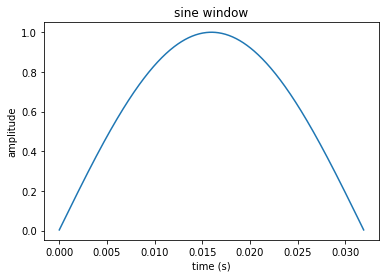

In [ ]:
win = np.sin(np.arange(.5,L-.5+1)/L*np.pi); # sine analysis window
time_axis = np.arange(0, L)/fs
plt.plot(time_axis, win)
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('sine window')

We verify that the perfect reconstruction condition (5) is satisfied with the sine window. We define an arbitrary number of time frames $N = 10$ for the overlap-add operation, such that $n=0,...,N-1$, and we compute the overlap-add in (5).

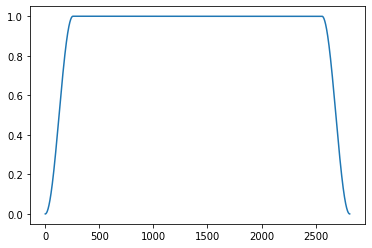

In [ ]:
N = 10
ola = np.zeros((N-1)*H+L) # array to save the result of the overlap-add

for n in np.arange(N):
    ind_beg = n*H
    ind_end = ind_beg+L
    ola[ind_beg:ind_end] += win**2
    
plt.plot(ola)

We indeed observe that except for the edges, relation (5) is verified. In practice, when computing the STFT, we will do some preprocessing (add zeros) to deal with edges. When computing the inverse STFT, we will apply the corresponding postprocessing (remove first and last coefficients) to ensure perfect reconstruction. Note that we would also simply divide by the overlap-add of the sine window after computing the inverse STFT.

<a id='II.2'></a>
### 2. STFT implementation

Let's first load a signal

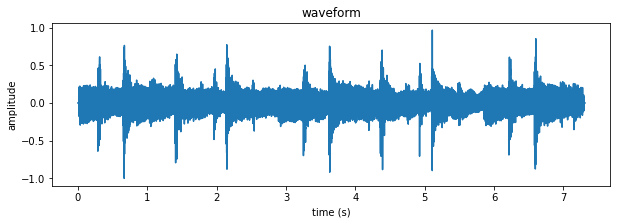

In [ ]:
import IPython.display as ipd

wavfile = '/content/piano_drums_mix.wav'

x, fs = sf.read(wavfile)
if len(x.shape)>1:
    x = x[:,0]
x = x/np.max(np.abs(x))
x = preprocessing(x, L, H) # some preprocessing to deal with edges and ensure perfect reconstruction
T = x.shape[0]

time_axis = np.arange(0, T)/fs
plt.figure(figsize=(10,3))
plt.plot(time_axis, x)
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('waveform')

ipd.Audio(x, rate=fs) 

### Exercise

Complete the following cell to implement the STFT. 

You have to:

- Loop over the number of frames $n = 0, ..., N-1$.
- At each time frame, select the appropriate portion of the signal, and multiply it with the sine window as in equation (2). You should end-up with an array of dimension $L$.
- Compute the discrete Fourier transform (DFT) (over $L$ points) of the frame (use np.fft.fft) as in equation (1).
- Exploiting the Hermitian symmetry property, discard the redundant part of the spectrum, by only keeping the first part of the spectrum (until Nyquist frequency, included). You should end-up with an array of dimention $F=L/2 + 1$.

In [ ]:
N = np.int( (T-L)/H ) + 1 # number of time frames

X = np.zeros( (F, N), dtype=np.cfloat )

#### TO COMPLETE ####
for n in np.arange(N):
    beg_frame = n*H
    end_frame = beg_frame + L
    x_n = x[beg_frame:end_frame]*win
    X_n = np.fft.fft(x_n)
    X[:,n] = X_n[:F]

<ipython-input-9-e67acb38b65a>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  N = np.int( (T-L)/H ) + 1 # number of time frames


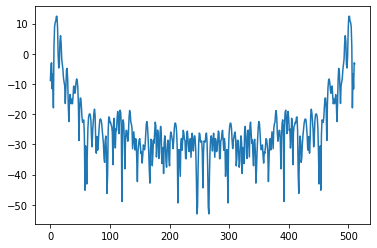

512


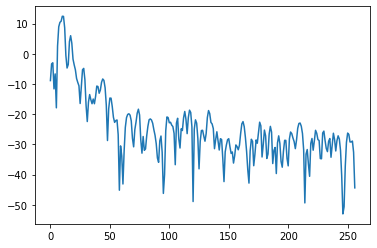

512


In [ ]:
plt.plot(10*np.log10(np.abs(X_n)**2))
plt.show()
print(L)

plt.plot(10*np.log10(np.abs(X_n[:F])**2))  # Only positive frequencies
plt.show()
print(L)

Below, we display the resulting power spectrogram.

Text(0.5, 1.0, 'power spectrogram')

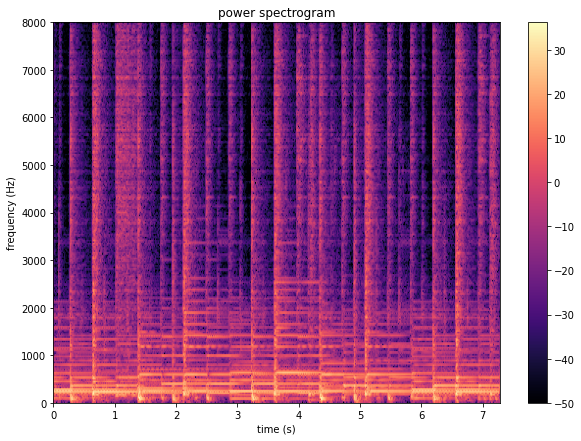

In [ ]:
X2_dB = 10*np.log10(np.abs(X)**2) # power spectrogram in dB

plt.figure(figsize=(10,7))
plt.imshow(X2_dB, origin='lower',  aspect='auto', cmap='magma', extent=[0, (N-1)*H/fs, 0, fs/2])

plt.clim(vmin=-50, vmax=None)
plt.colorbar()   
plt.xlabel('time (s)')
plt.ylabel('frequency (Hz)')
plt.title('power spectrogram')

### Exercise

1. How would you describe the difference between the spectrogram of the piano and drums signals (```piano_scale.wav``` and ```drums.wav``` in the ```data``` directory).

2. What is the effect of the analysis window length?

3. Would you choose the same window length for computing the spectrograms of the drums and piano signals?

4. Load ```piano_drums_mix.wav``` and look at its spectrogram. We would like to decompose this spectrogram into the sum of two spectrograms, one for the piano, one for the drums. What properties would you like to enforce in each of these two spectrograms?

<a id='II.3'></a>
### 3. Inverse STFT implementation

The following cell implements the inverse STFT. 

The process is:

- Loop over the number of frames $n = 0, ..., N-1$.
- For each frame, restore the Hermitian symmetry of the spectrum. You should end-up with an array of dimension $L$.
- Compute the inverse DFT (use np.fft.ifft) as in equation (4).
- Compute overlap-add, as in equation (3), similarly as what has been done to compute the `ola` array in Section 1.

In [ ]:
x_hat = np.zeros((N-1)*H + L)

X_n_complete = np.zeros(L, dtype=np.cfloat)

for n in np.arange(N):
#### TO COMPLETE ####
    X_n = X[:,n] # length F = L/2 + 1
    X_n_complete[:F] = X_n
    X_n_complete[F:] = np.conj(np.flipud(X_n[1:-1]))
    x_n_hat = np.real(np.fft.ifft(X_n_complete))
    ind_beg = n*H
    ind_end = ind_beg+L
    x_hat[ind_beg:ind_end] += x_n_hat*win

Plot the reconstruction error (i.e. the difference between `x` and `x_hat`) in the next cell.

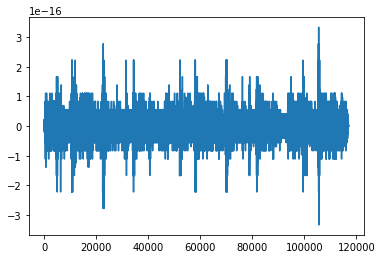

In [ ]:
plt.plot(x-x_hat)

<a id='II.4'></a>
### 4. Analysis-transformation-synthesis

You are a DJ looking for new awesome audio effects, and you have this great idea of filtering acid techno music with an oscillating Gaussian in the STFT domain (yes your are also quite familiar with signal processing). Let's implement it!

In [ ]:
x, fs = sf.read('/content/acid.wav')
T = x.shape[0]
ipd.Audio(x, rate=fs) 

Output hidden; open in https://colab.research.google.com to view.

We use [librosa](https://librosa.org/doc/latest/index.html) to compute the STFT.

Text(0.5, 1.0, 'power spectrogram')

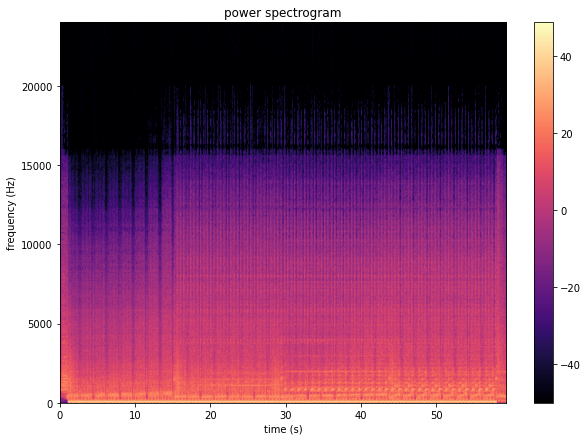

In [ ]:
import librosa

wlen_sec = 32e-3 # STFT window length in seconds
hop_percent = 0.5  # hop size as a percentage of the window length
L = wlen_sec*fs # window length in samples
L = int(np.power(2, np.ceil(np.log2(L)))) # round to the next power of 2 to fasten fft 
H = int(hop_percent*L) # hop size in samples
nfft = L # number of points (i.e. order) of the discrete Fourier transform
F = L//2 + 1  # number of positive frequency bins

X = librosa.stft(x, n_fft=nfft, hop_length=H)

N = X.shape[1]

X2_dB = 10*np.log10(np.abs(X)**2) # power spectrogram in dB

plt.figure(figsize=(10,7))
plt.imshow(X2_dB, origin='lower',  aspect='auto', cmap='magma', extent=[0, (N-1)*H/fs, 0, fs/2])

plt.clim(vmin=-50, vmax=None)
plt.colorbar()   
plt.xlabel('time (s)')
plt.ylabel('frequency (Hz)')
plt.title('power spectrogram')

In the following cell, we design the oscillating Gaussian filter, with a length of 10 seconds.

Text(0.5, 1.0, 'time-frequency filter')

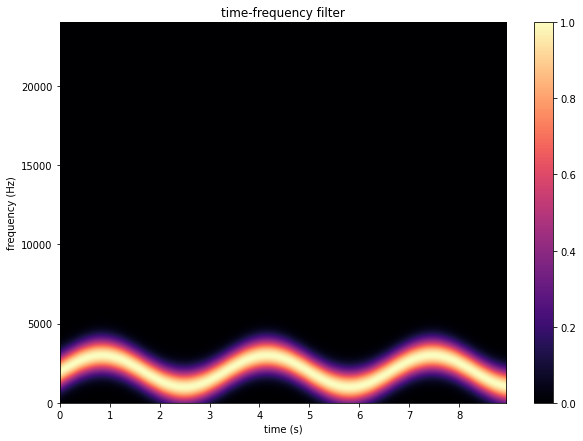

In [ ]:
T_filt = 9*fs
N_filt = int( (T_filt-L)/H ) + 1 # number of time frames

t = np.linspace(0, T_filt/fs, N_filt) # vector of time indices in seconds
osc_freq = 0.3 # frequency of the oscillation in Hz
center_frequency = 2000 + 1000 * np.sin(2*np.pi*osc_freq*t) # center frequency of the band-pass filter in Hz
width = 1000.0 # width of the Gaussian
# generates a Gaussian over the frequency axis with a given center and width
gauss = lambda x, mu: 2.0 * np.pi * width**-2.0 * np.exp(- ((x - mu) / width)**2.0) 

frequencies = np.linspace(0, fs/2, F) # vector of frequency indices in Hz
TF_filter = np.array([gauss(frequencies, cf) for cf in center_frequency]).T # time-frequency magnitude filter
TF_filter /= TF_filter.max(axis=0, keepdims=True) # normalize to be between 0 and 1

plt.figure(figsize=(10,7))
plt.imshow(TF_filter, origin='lower',  aspect='auto', cmap='magma', extent=[0, (N_filt-1)*H/fs, 0, fs/2])

plt.colorbar()   
plt.xlabel('time (s)')
plt.ylabel('frequency (Hz)')
plt.title('time-frequency filter')

# You are filtering the highest frequencies

### Exercise

Apply the filter to a portion of your choice of the original signal.

Text(0.5, 1.0, 'power spectrogram')

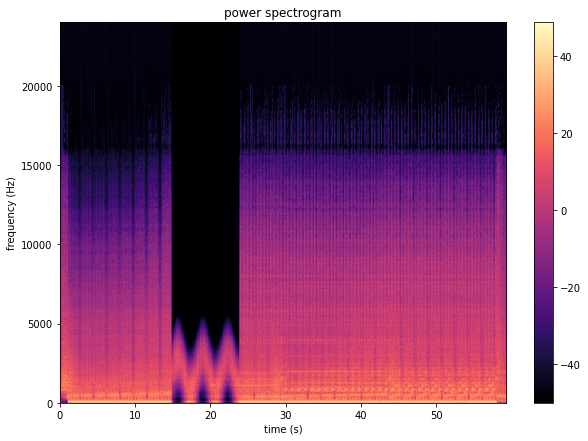

In [ ]:
#### TO COMPLETE ####
X_filt = np.zeros_like(X)
X_filt[:] = X
X_filt[:,N//4:N//4+N_filt] = TF_filter*X_filt[:,N//4:N//4+N_filt] 
####################

X2_filt_dB = 10*np.log10(np.abs(X_filt)**2 + 1e-5) # power spectrogram in dB

plt.figure(figsize=(10,7))
plt.imshow(X2_filt_dB, origin='lower',  aspect='auto', cmap='magma', extent=[0, (N-1)*H/fs, 0, fs/2])

plt.clim(vmin=-50, vmax=None)
plt.colorbar()   
plt.xlabel('time (s)')
plt.ylabel('frequency (Hz)')
plt.title('power spectrogram')

Invert the STFT to reconstruct a time-domain signal.

In [ ]:
x_filt = librosa.istft(X_filt, hop_length=H, win_length=L, length=T)

Plot and listen to the resulting audio signal.

In [ ]:
time_axis = np.arange(0, T)/fs
plt.figure(figsize=(10,3))
plt.plot(time_axis, x_filt)
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('waveform')

ipd.Audio(x_filt, rate=fs) 

Output hidden; open in https://colab.research.google.com to view.